## Getting data from the full dataset via: CAVEclient('minnie65_public')

In [1]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils, skeletonize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from caveclient import CAVEclient
import meshparty.skeleton_io

In [2]:
some_id = 864691135568539372 #864691135207734905 # a root id from aibs_metamodel_mtypes_v661_v2	table

## Get Mesh / Skeleton

In [3]:
def plot_sk_or_mesh(sk_or_mesh, in_3d=True, sample=50, soma=None, syn_list=None, syn_size=1,
                    ex_syn=None, inh_syn=None):
    if in_3d:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')

        if soma is not None:
            ax.scatter3D(soma[0], soma[1], soma[2], c='red', s=200, alpha=1, label='soma')
        if syn_list is not None:
            ax.scatter3D(syn_list[:,0], syn_list[:,1], syn_list[:,2], c='purple', s=syn_size, alpha=.8, label='syn')
        if ex_syn is not None:
            ax.scatter3D(ex_syn[:,0], ex_syn[:,1], ex_syn[:,2], c='green', s=syn_size, alpha=.8, label='ex syn')
        if inh_syn is not None:
            ax.scatter3D(inh_syn[:,0], inh_syn[:,1], inh_syn[:,2], c='purple', s=syn_size, alpha=.8, label='in syn')
        
        ax.scatter3D(sk_or_mesh.vertices[::sample,0],
                     sk_or_mesh.vertices[::sample,1],
                     sk_or_mesh.vertices[::sample,2], s=0.8, alpha=.5, label='mesh/sk')
    else: 
        f,ax = plt.subplots(figsize=(8,8))
        ax.scatter(sk_or_mesh.vertices[::sample,0], sk_or_mesh.vertices[::sample,1], s=1, alpha=.2, label='mesh/sk')
    
        if soma is not None:
            ax.scatter(soma[0], soma[1], c='red', s=100, alpha=0.9, label='soma')
        if syn_list is not None:
            ax.scatter(syn_list[:,0], syn_list[:,1], c='purple', s=syn_size, alpha=.8, label='syn')
        if ex_syn is not None:
            ax.scatter(ex_syn[:,0], ex_syn[:,1], c='green', s=syn_size, alpha=.9, label='ex syn')
        if inh_syn is not None:
            ax.scatter(inh_syn[:,0], inh_syn[:,1], c='purple', s=syn_size, alpha=.9, label='inh syn')
            
        ax.set_aspect('equal')
        ax.set_ylim(np.max(sk_or_mesh.vertices[:,1]), np.min(sk_or_mesh.vertices[:,1]))

    lgnd = plt.legend(scatterpoints=1)
    for handle in lgnd.legend_handles:
        handle.set_sizes([50.0])

In [4]:
# the full dataset
client = CAVEclient('minnie65_public')

# Download mesh
mm = trimesh_io.MeshMeta(
  cv_path=client.info.segmentation_source(),
  disk_cache_path="data",
)

mesh = mm.mesh(seg_id=some_id, remove_duplicate_vertices=True)
mesh.vertices.shape

(1508981, 3)

In [5]:
# Download skeleton
sk_dict = client.skeleton.get_skeleton(some_id, output_format='json')
sk_dict.keys()

sk = meshparty.skeleton.Skeleton(
    vertices=np.array(sk_dict['vertices']),
    edges=np.array(sk_dict['edges']),
    mesh_to_skel_map=sk_dict['mesh_to_skel_map'],
    vertex_properties=sk_dict['vertex_properties'],
    root=sk_dict['root'],
    meta=sk_dict['meta'],
)
print(sk.vertices.shape)

(1221, 3)


In [6]:
# Calcualte skeleton based on the mesh
sk_calculated = skeletonize.skeletonize_mesh(mesh, invalidation_d=12000)
print(type(sk_calculated))
print(sk_calculated.vertices.shape)

C:\Users\dean\Documents\dev\Connectomics\OFS-EM-Connectomics\.venv\lib\site-packages\meshparty\skeletonize.py:622: RuntimeWarning: invalid value encountered in multiply
  target = np.nanargmax(root_ds * valid)


<class 'meshparty.skeleton.Skeleton'>
(25660, 3)


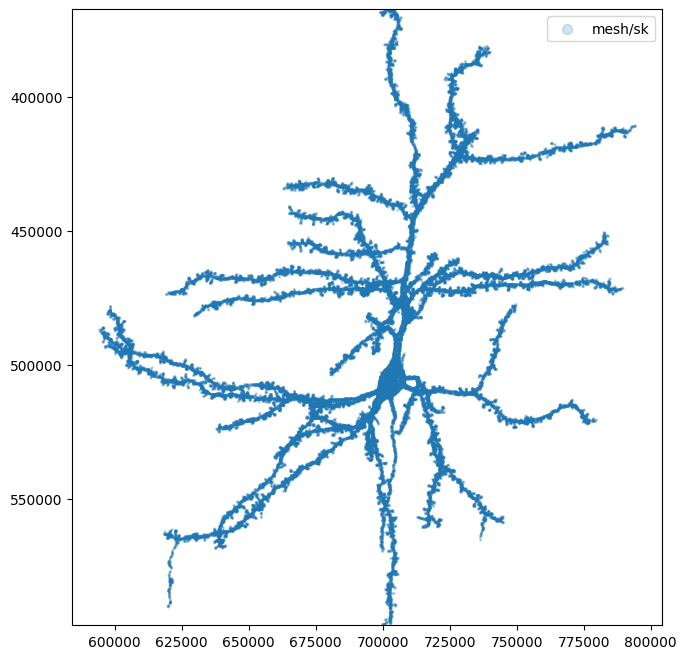

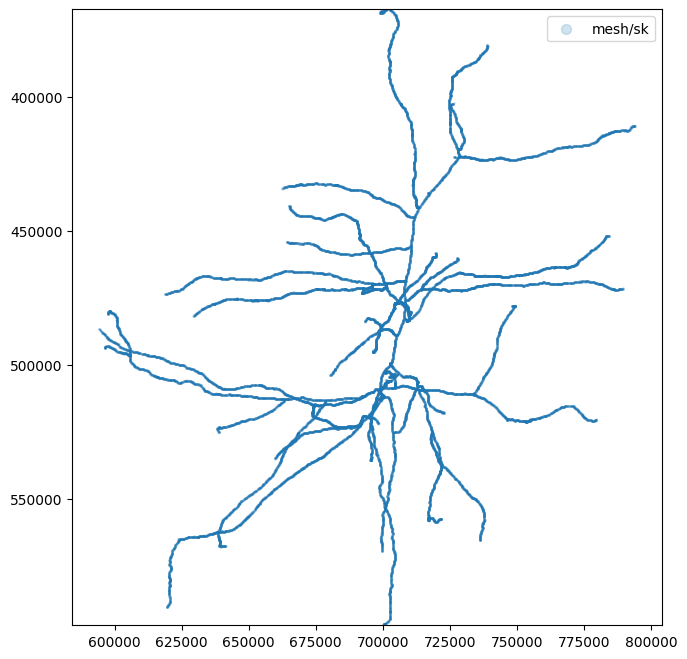

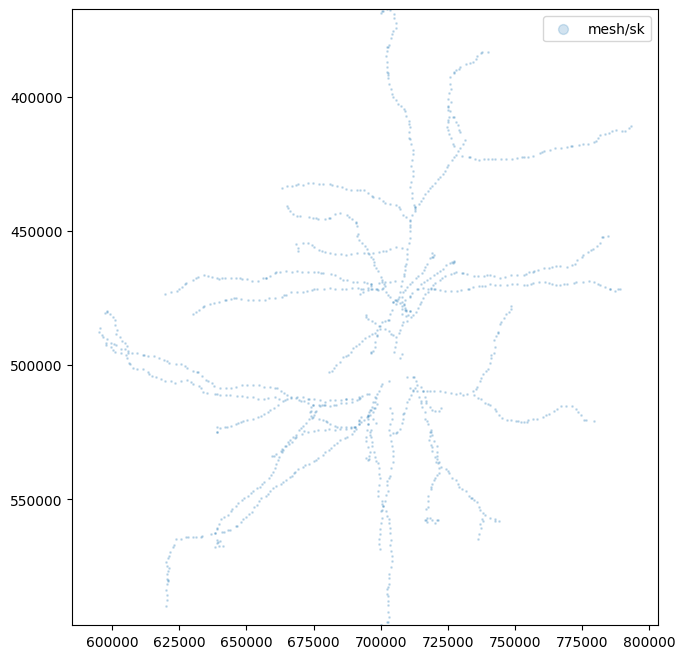

In [7]:
plot_sk_or_mesh(mesh, in_3d=False, sample=20)
plot_sk_or_mesh(sk_calculated, in_3d=False, sample=1)
plot_sk_or_mesh(sk, in_3d=False, sample=1)


## Get Synapses + Soma

In [8]:
soma_table_file = 'data/aibs_metamodel_mtypes_v661_v2.csv'
soma_df = pd.read_csv(soma_table_file)

print(len(soma_df))
# some root ids are 0...
print(len(set(soma_df.root_id.unique())))

72158
71992


In [9]:
syn_df = client.materialize.synapse_query(pre_ids=some_id)
print(f"Total number of output synapses for {some_id}: {len(syn_df)}")

Total number of output synapses for 864691135568539372: 24


In [10]:
cell_post_subgraph = client.materialize.synapse_query(post_ids=some_id)
print(f"Total number of input synapses for {some_id}: {len(cell_post_subgraph)}")
cell_post_subgraph.head()

Total number of input synapses for 864691135568539372: 3000


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,165264279,2020-11-04 06:49:10.903020+00:00,NaN,t,3876,89725921262762730,864691135641449041,89725989982231406,864691135568539372,"[181286, 104118, 15022]","[181430, 104202, 15020]","[181362, 104184, 15025]"
1,180297181,2020-11-04 06:48:58.480065+00:00,NaN,t,2608,90855326064337331,864691135401791730,90855326064349793,864691135568539372,"[189710, 129924, 16605]","[189626, 130022, 16613]","[189644, 130012, 16611]"
2,151980276,2020-11-04 06:49:08.606602+00:00,NaN,t,1508,88743988659981552,864691136585959908,88743988659980705,864691135568539372,"[174522, 127972, 15282]","[174556, 128052, 15283]","[174564, 128024, 15281]"
3,159316317,2020-11-04 06:52:06.163446+00:00,NaN,t,8224,88951246735688530,864691135500602052,88951246735677859,864691135568539372,"[175966, 99386, 15953]","[175944, 99316, 15951]","[175956, 99368, 15956]"
4,160398374,2020-11-04 06:51:43.289973+00:00,NaN,t,11464,89448157271886582,864691136749727086,89448157271897027,864691135568539372,"[179496, 131682, 15899]","[179506, 131742, 15904]","[179482, 131712, 15902]"


Synapses: 3000
Soma loc [nM]: [703040 505920 620160]


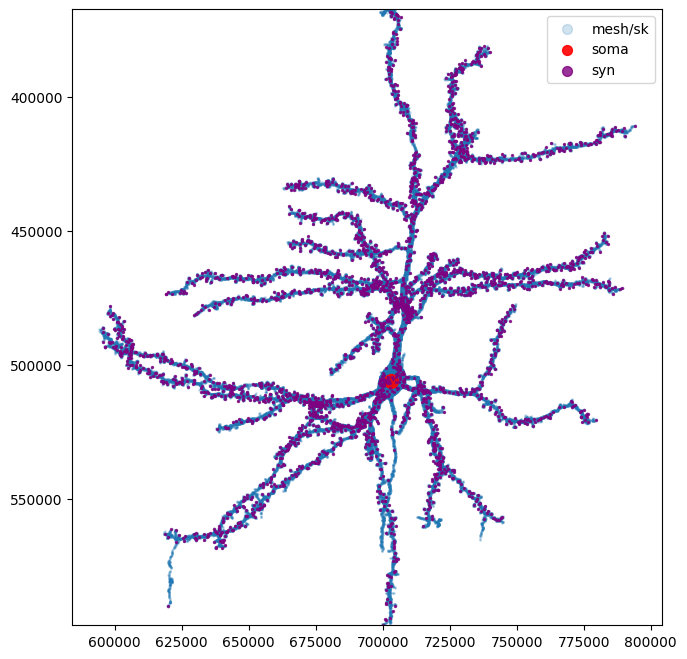

In [11]:
print(f'Synapses: {len(cell_post_subgraph)}')
# convert voxel to nM
syn_xyz = np.array(cell_post_subgraph.ctr_pt_position.tolist()) * np.array([4,4,40])

# Handle Soma
soma_cell_df = soma_df.query(f'root_id =={some_id}')
if len(soma_cell_df) > 1:
    print('err?')

soma_xyz = soma_cell_df.iloc[0][['pt_position_x', 'pt_position_y', 'pt_position_z']].values
print(f'Soma loc [nM]: {soma_xyz}')

plot_sk_or_mesh(mesh, in_3d=False, sample=20, soma=soma_xyz, syn_list=syn_xyz, syn_size=2)

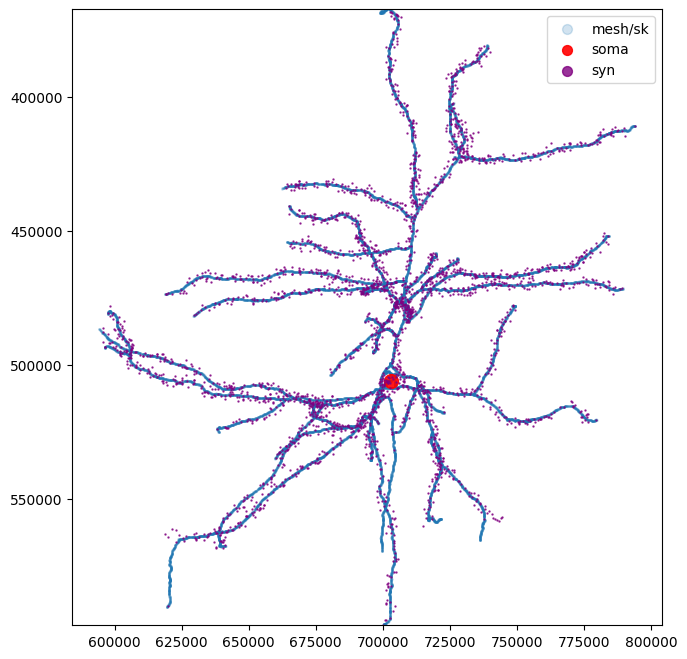

In [12]:
plot_sk_or_mesh(sk_calculated, in_3d=False, sample=1, soma=soma_xyz, syn_list=syn_xyz, syn_size=0.5)

### Get the type of those presynaptic neurons

Ex  Synapses: 46
Inh Synapses: 61


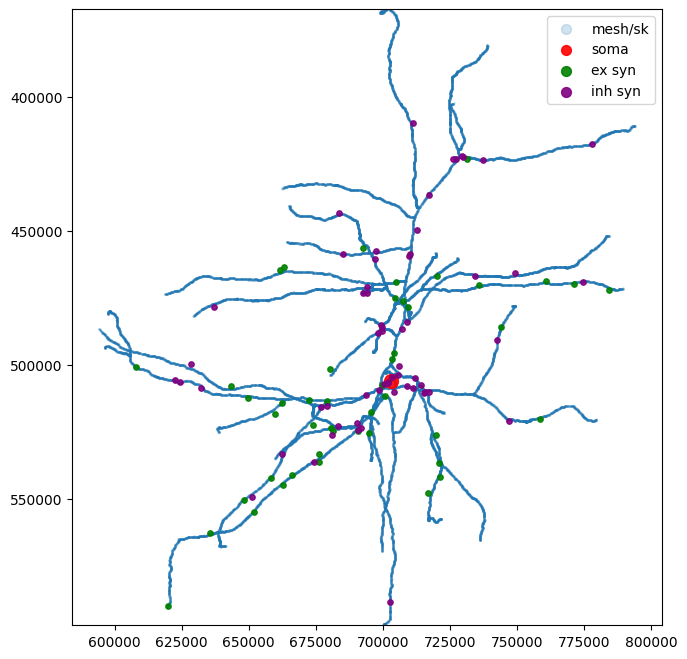

In [13]:
inh_root_ids = set(soma_df.query('classification_system=="inhibitory_neuron"')['root_id'].values)
ex_root_ids = set(soma_df.query('classification_system=="excitatory_neuron"')['root_id'].values)

inh_syn_df = cell_post_subgraph.query('pre_pt_root_id in @inh_root_ids')
ex_syn_df = cell_post_subgraph.query('pre_pt_root_id in @ex_root_ids')

print(f'Ex  Synapses: {len(ex_syn_df)}')
print(f'Inh Synapses: {len(inh_syn_df)}')

inh_syn_xyz = None
if len(inh_syn_df):
    inh_syn_xyz = np.array(inh_syn_df.ctr_pt_position.tolist()) * np.array([4,4,40])

ex_syn_xyz = None
if len(ex_syn_df):
    ex_syn_xyz = np.array(ex_syn_df.ctr_pt_position.tolist()) * np.array([4,4,40])

plot_sk_or_mesh(sk_calculated, in_3d=False, sample=1, soma=soma_xyz, ex_syn=ex_syn_xyz, inh_syn=inh_syn_xyz, syn_size=15)

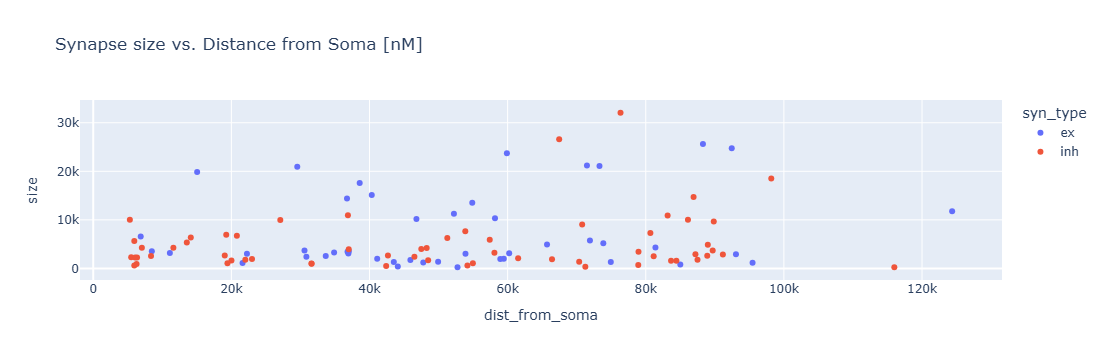

In [17]:
# TODO: fix euclid distance to dikstra / over the tree
import plotly.express as px
pd.options.mode.copy_on_write = True

def synapse_dist_from_soma(syn):
    syn_xyz = syn.ctr_pt_position.tolist() * np.array([4,4,40])
    return np.linalg.norm(soma_xyz - syn_xyz)

inh_syn_df['dist_from_soma'] = inh_syn_df.apply(synapse_dist_from_soma, axis=1).copy()
inh_syn_df['syn_type'] = 'inh'

ex_syn_df['dist_from_soma'] = ex_syn_df.apply(synapse_dist_from_soma, axis=1).copy()
ex_syn_df['syn_type'] = 'ex'

syn_df = pd.concat([ex_syn_df, inh_syn_df])
fig = px.scatter(syn_df, x="dist_from_soma", y="size", color="syn_type",
                 title="Synapse size vs. Distance from Soma [nM]")
fig.show()